# Reproducing LS11 Using HadCRUT4-gl

Loehle and Scafetta (2011) (hereafter LS11) propose a model for global mean surface temperatures (GMST) where the natural component is composed of a linear term and two cyclic terms, with periods of 20 and 60 years, to which a linear term is added (from approximately 1942 onwards) representing anthropogenic influences:

\begin{equation*}
   y(t) = A \cos\left[2\pi(t - T_1)/60 \right] + B \cos\left[2\pi(t - T_2)/20 \right] + C(t-1900) + D + \max\left[E + F\times(t-1950), 0\right].
\end{equation*}

The parameters of this model, taken from LS11 are as follows:

\begin{equation*}
   A = 0.121,~~
   B = 0.041,~~
   C = 0.0016,~~
   D = -0.317,~~
   E = 0.054,~~
   F = 0.0066,~~
   T_1 = 1998.58,~~
   T_2 = 1999.65.
\end{equation*}

In this notebook, we will instead try to infer the parameters of the model from the data via non-linear least-squares, using HadCRUT4-gl, just to check that the results are not substantially different to those obtained using hadCRUT3-gl.

First we import libraries for maths functions etc., plotting and downloading data:

In [1]:
import numpy as np;
import matplotlib.pyplot as plt
import urllib.request
from scipy.optimize import least_squares 

Next, we download the HadCRUT4-gl dataset from CRU webserver and extract the data, which are on alternate lines of the file.  The year is in the first column and the annual global mean surface temperature anomaly is in the last column.  

In [2]:
response = urllib.request.urlopen('https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT4-gl.dat')
year, temp = [], [];
for count, line in enumerate(response, start=1):
    if count % 2 == 1:
        line = line.split();
        year.append(int(line[0]))
        temp.append(float(line[-1]))

We then define a function that implements the LS11 model.  This time, rather than the parameters being hard-coded as in the previous notebook, they are provided as an argument.  The arguments expected to be numpy array objects.

In [3]:
def ls11(year, theta) : 
    return (  theta[3] 
            + theta[2]*(year - 1900) 
            + theta[1]*np.cos(2*np.pi*(year - theta[7])/20) 
            + theta[0]*np.cos(2*np.pi*(year - theta[6])/60) 
            + np.maximum(theta[4] + theta[5]*(year-1950), 0))

Just as a sanity check, reproduce the graph uwing an array of model parameters as given by LS11:

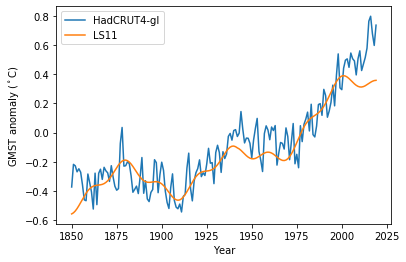

In [4]:
theta = np.array([0.121, 0.041, 0.0016, -0.317, 0.054, 0.0066, 1998.58, 1999.65]);
year  = np.array(year);
temp  = np.array(temp);
pred  = ls11(year, theta);
plt.plot(year, temp, year, pred);
plt.ylabel('GMST anomaly ($^\circ$C)');
plt.xlabel('Year');
plt.legend(['HadCRUT4-gl', 'LS11']);

Attempt to fit the natural component of the model via non-linear least-squares optimisation, using the same calibration period (1850-1950)

In [5]:
def ls11natural(year, theta) : 
    return (  theta[3] 
            + theta[2]*(year - 1900) 
            + theta[1]*np.cos(2*np.pi*(year - theta[7])/20) 
            + theta[0]*np.cos(2*np.pi*(year - theta[6])/60))

def fun(theta, year, temp):
    return ls11natural(year, theta) - temp

idx    = year <= 1950;
result = least_squares(fun, theta.copy(), loss='linear', args=(year[idx], temp[idx]));
phi    = result.x;

Plot the natural component:

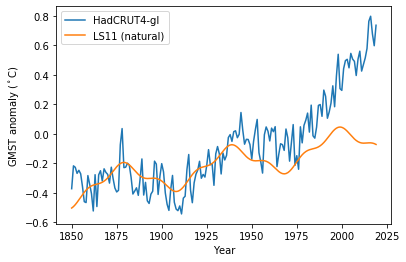

In [6]:
pred  = ls11natural(year, result.x);
plt.plot(year, temp, year, pred);
plt.ylabel('GMST anomaly ($^\circ$C)');
plt.xlabel('Year');
plt.legend(['HadCRUT4-gl', 'LS11 (natural)']);

Fit the anthropogenic component of the model to the residuals for 1950-2010.  Note that the residuals from 1950 can no longer be reasonably modelled by a linear function, which suggests the Loehle and Scafetta approach is not robust to the choice of the dataset, which is not a reassuring finding.

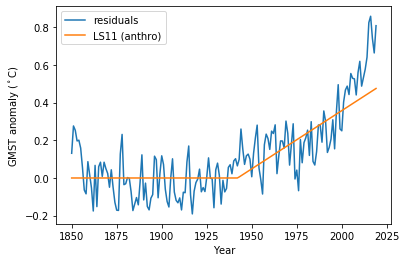

In [7]:
idx = (year >= 1950) & (year <= 2010);
X = np.array([np.ones(year[idx].shape), year[idx]-1950]).T;
y = temp[idx] - pred[idx];
phi[4:6] = (np.linalg.pinv(X.T@X)@(X.T@y));
plt.plot(year, temp-pred, year, np.maximum(phi[5]*(year-1950) + phi[4], 0));
plt.ylabel('GMST anomaly ($^\circ$C)');
plt.xlabel('Year');
plt.legend(['residuals', 'LS11 (anthro)']);

Lastly plot the natural and anthropogenic components

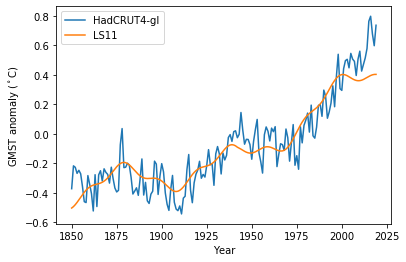

In [8]:
pred  = ls11(year, phi);
plt.plot(year, temp, year, pred);
plt.ylabel('GMST anomaly ($^\circ$C)');
plt.xlabel('Year');
plt.legend(['HadCRUT4-gl', 'LS11']);

Lastly, looking a residuals between the two sets of parameters, they seem in reasonably good agreement (at least to within the precision of the figures given in the paper).

In [9]:
(theta-phi).T

array([ 2.20190967e-02,  1.12172038e-02, -3.99362314e-04, -3.66871982e-02,
        5.36077687e-03,  4.15633371e-04,  8.07528335e-01,  8.97103471e-01])

## References:

[LS11] Craig Loehle and Nicola Scafetta, "Climate Change Attribution Using Empirical Decomposition of Climate Data", <i>The Open Atmospheric Science Journal</i>, volume 5, pages 74-86, 2011.